In [35]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm as colormap

def SolvePoisson(numxbins, numybins, numzbins, is_boundary, f_bound, f_rho, epsilon = 1e-5, imax = 1000):

    ## Initialize the mesh with default values of zero
    V = [[[0 for i in range(numzbins+1)] for j in range(numybins+1)] for k in range(numzbins+1)]
    rho = [[[0 for i in range(numzbins+1)] for j in range(numybins+1)] for k in range(numzbins+1)]

    ## Set boundary conditions for the problem
    for i in range(numxbins+1):
        for j in range(numybins+1):
            for k in range(numzbins + 1):
                if (is_boundary(i,j,k)):
                    V[i][j][k] = f_bound(i,j,k)
                rho[i][j][k] = f_rho(i,j,k)
                                   
    ## Store previous grid values to check against error tolerance
    Vnext = V + np.zeros((numxbins+1, numybins+1, numzbins+1))
    error = Vnext - V

    ## Constants
    k = 1          ## counter

    ## Iterative procedure
    while k <= imax:
        errmax = 0
        # Iterate over the two dimensional space
        for i in np.arange(1, numxbins):

            for j in np.arange(1,  numybins):
                
                for l in np.arange(1, numzbins):
                    # Calculate the new value of the potential at this point
                    # and the difference with respect to the previous value
                    ##   --> what are we missing here?
                    if (not is_boundary(i,j,l)):
                        Vnext[i][j][l] = (V[i-1][j][l] + V[i+1][j][l] + V[i][j-1][l] + V[i][j+1][l] + V[i][j][l-1] + V[i][j][l+1] + rho[i][j][l])/6.
                    if np.abs(Vnext[i][j][l] - V[i][j][l]) > errmax:
                        errmax = np.abs(Vnext[i][j][l] - V[i][j][l])

        # Set the potential to the newly calculated value and increment the counter
        V = Vnext + np.zeros((numxbins+1, numybins+1, numzbins+1))
        k += 1
        print(k, errmax)
        

        # Determine if the maximum error across the mesh is smaller than the specified 
        # tolerance
        if errmax < epsilon:

            print("Convergence after ", k, " iterations.")
            return V

    print("No convergence after ", k, " iterations.")
    return False

def PlotSolution(numxbins,numybins,stepsize,V, x0 = 0, y0 = 0, x1=0, y1=0, levels = []):
    if x1 == 0:
        x1 = numxbins
    if y1 == 0:
        y1 = numybins
    
    V_plot = [[V[i][j] for j in range(y0,y1)] for i in range(x0,x1)]
    len_x, len_y = len(V_plot), len(V_plot[0])
    V_plot = V_plot + np.zeros((len_x, len_y))

    ## Set up x and y vectors for meshgrid
    x = np.linspace(x0*stepsize, x1 * stepsize, len_x)
    y = np.linspace(y0*stepsize, y1 * stepsize, len_y)

    # set up a figure that is wider than it is tall since we want the figures
    # to be side by side
    figure = plt.figure(figsize=(20,8),dpi=300)
    mycmap = colormap.plasma
    
    
    # set up the axes for the first plot
    ax = figure.add_subplot(1, 2, 1, projection='3d')
    X,Y  = np.meshgrid(x,y)
    surf = ax.plot_surface(X, Y, V_plot.transpose(), cmap=mycmap, linewidth=0, antialiased=False)
    ax.set_xlabel("y")
    ax.set_ylabel("z")
    ax.set_zlabel("V(y,z)")

    # set up the axes for the second plot
    ax = figure.add_subplot(1, 2, 2)
    cs   = plt.contourf(X, Y, V_plot.transpose(), 32, cmap=mycmap)
    cbar = plt.colorbar()
    cbar.set_label('V(y,z)')
    plt.xlabel("y")
    plt.ylabel("z")
    
    # Plot contour lines
    figure = plt.figure(figsize=(10,4),dpi=200)
    ax = figure.add_subplot(1, 2, 1)
    if levels == []:
        CS = ax.contour(X, Y, V_plot.transpose())
    else:
        CS = ax.contour(X, Y, V_plot.transpose(), levels = levels)
    ax.clabel(CS, inline=1, fontsize=10)

    plt.show()
    
def SolvePoisson_BI(numxbins, numybins, numzbins, is_boundary, f_bound, f_rho, E0, epsilon = 1e-5, imax = 1000, d = 1):

    ## Initialize the mesh with default values of zero
    V = [[[0 for i in range(numzbins+1)] for j in range(numybins+1)] for k in range(numzbins+1)]
    rho = [[[0 for i in range(numzbins+1)] for j in range(numybins+1)] for k in range(numzbins+1)]

    ## Set boundary conditions for the problem
    for i in range(numxbins+1):
        for j in range(numybins+1):
            for k in range(numzbins + 1):
                if (is_boundary(i,j,k)):
                    V[i][j][k] = f_bound(i,j,k)
                rho[i][j][k] = f_rho(i,j,k)
    
    ## Store previous grid values to check against error tolerance
    Vnext = V + np.zeros((numxbins+1, numybins+1, numzbins+1))
    error = Vnext - V

    ## Constants
    k = 1          ## k is just is a counter

    ## Iterative procedure
    while k <= imax:
        errmax = 0
        # Iterate over the two dimensional space
        for i in range(1, numxbins):

            for j in range(1,  numybins):
                
                for l in range(1, numzbins):
                    if (not is_boundary(i,j,l)):
                        E_p_2 = ((V[i+1][j][l]-V[i][j][l])/d)**2 + ((V[i][j+1][l]-V[i][j][l])/d)**2 + ((V[i][j][l+1]-V[i][j][l])/d)**2
                        E_mx_2 = ((V[i][j][l]-V[i-1][j][l])/d)**2 + ((V[i-1][j+1][l]-V[i-1][j][l])/d)**2 + ((V[i-1][j][l+1]-V[i-1][j][l])/d)**2
                        E_my_2 = ((V[i+1][j-1][l]-V[i][j-1][l])/d)**2 + ((V[i][j][l]-V[i][j-1][l])/d)**2 + ((V[i][j-1][l+1]-V[i][j-1][l])/d)**2
                        E_mz_2 = ((V[i+1][j][l-1]-V[i][j][l-1])/d)**2 + ((V[i][j+1][l-1]-V[i][j][l-1])/d)**2 + ((V[i][j][l]-V[i][j][l-1])/d)**2
                        gamma_p = 1/np.sqrt(1-E_p_2/E0**2)
                        gamma_mx = 1/np.sqrt(1-E_mx_2/E0**2)
                        gamma_my = 1/np.sqrt(1-E_my_2/E0**2)
                        gamma_mz = 1/np.sqrt(1-E_mz_2/E0**2)
                        Vnext[i][j][l] = (V[i-1][j][l]*gamma_mx + V[i+1][j][l]*gamma_p + V[i][j-1][l]*gamma_my + V[i][j+1][l]*gamma_p + V[i][j][l+1]*gamma_p + V[i][j][l-1]*gamma_mz + rho[i][j][l])/d**2/(3*gamma_p+gamma_mx+gamma_my+gamma_mz)
                    if np.abs(Vnext[i][j][l] - V[i][j][l]) > errmax:
                        errmax = np.abs(Vnext[i][j][l] - V[i][j][l])

        # Set the potential to the newly calculated value and increment the counter
        V = Vnext + np.zeros((numxbins+1, numybins+1, numzbins+1))
        k += 1
        print(k, errmax)
        

        # Determine if the maximum error across the mesh is smaller than the specified 
        # tolerance
        if errmax < epsilon:

            print("Convergence after ", k, " iterations.")
            return V

    print("No convergence after ", k, " iterations.")
    return False

def optimize(guess,steps,low,high,x,y,f_model):
    xs = np.linspace(guess*low,guess*high,steps)
    min_err =  np.sum( (f_model(xs[0],x[j])-y[j])**2 for j in range(len(x)))
    min_err_i = 0
    for i in range(1,steps):
        f = lambda x: f_model(xs[i],x)
        err = np.sum( (f(x[j])-y[j])**2 for j in range(len(x)))
        if err < min_err:
            min_err = err
            min_err_i = i
    return xs[min_err_i], min_err

In [2]:
## Size of plate and mesh
numxbins = 60
numybins = 60
numzbins = 60
stepsize = 1./60.

## Tolerance and failsafe
epsilon = 1e-4     ## Absolute Error tolerance
imax    = 1000    ## Maximum number of iterations allowed

is_bound = lambda x, y, z: y <= 31
f_bound = lambda x, y, z: 0
f_rho = lambda x, y, z: 10 if (x == 31 and y == 36 and z == 31) else 0

## Calculate the scalar function V
V_conducting_ground = SolvePoisson(numxbins, numybins, numzbins, is_bound, f_bound, f_rho, epsilon, imax)

2 1.6666666666666667
3 0.2777777777777778
4 0.2777777777777777
5 0.11574074074074076
6 0.1157407407407407
7 0.06644375857338819
8 0.06644375857338813
9 0.04438514517604031
10 0.0443851451760402
11 0.03231988740283498
12 0.03231985983921559
13 0.024880875365574373
14 0.024880668638428194
15 0.019914880328311457
16 0.019914060544582668
17 0.016406090162483955
18 0.016403901041817548
19 0.013818663876374537
20 0.01381411550401257
21 0.011845816719144753
22 0.011837843272534787
23 0.010300517104972262
24 0.010288130030597475
25 0.009062928984505114
26 0.009045324691093093
27 0.00805311401122799
28 0.008029727577813617
29 0.007215943374477507
30 0.007186457741285235
31 0.006512318886435109
32 0.006476644550934552
33 0.005913840439752516
34 0.005872079476694214
35 0.005399446535711672
36 0.005351851133867935
37 0.004953230737904546
38 0.004900162707087485
39 0.004562983691524969
40 0.0045048784326877644
41 0.004219196509986922
42 0.004156532910547739
43 0.003914365346003312
44 0.003847641816

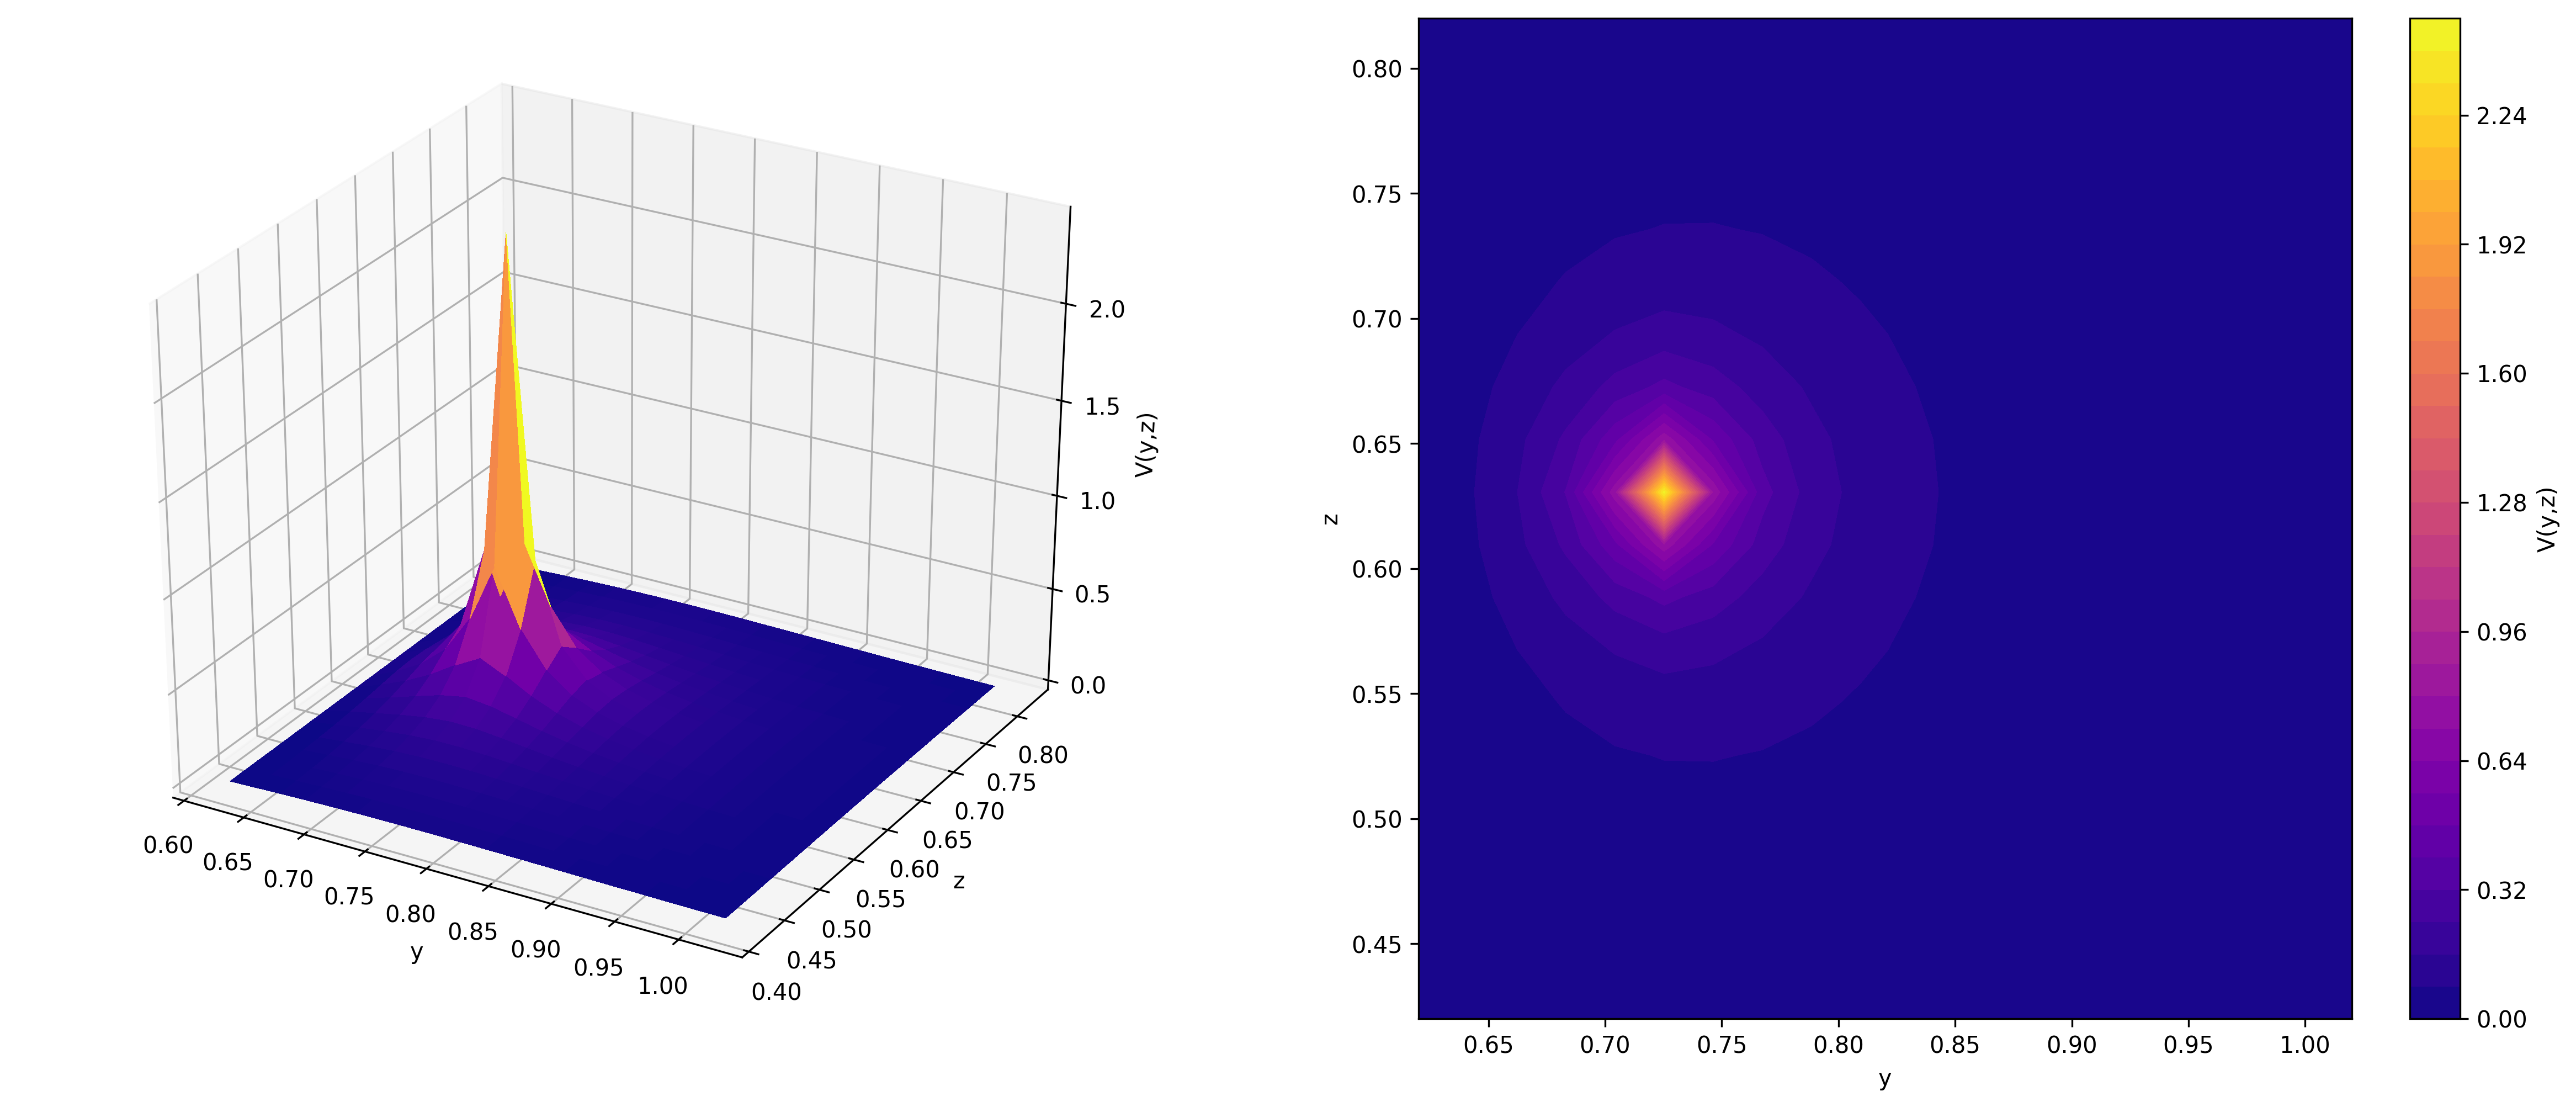

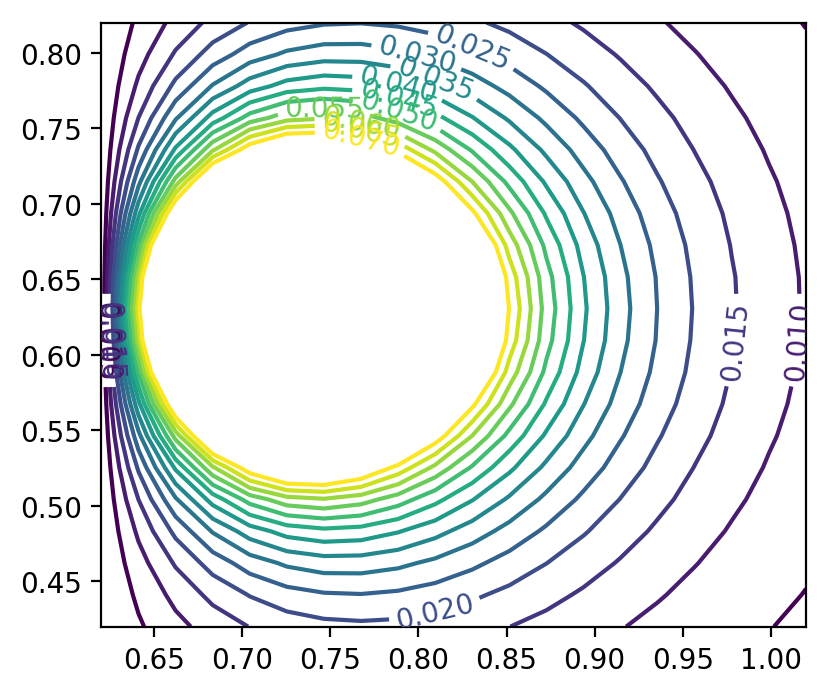

In [37]:
## Plot V
PlotSolution(numxbins, numybins, stepsize, V_conducting_ground[31], x0 = 31, x1 = 51, y0 = 21, y1 = 41, levels = [0 + i * 0.005 for i in range(15)])
plt.show()

In [8]:
## Size of plate and mesh
numxbins = 60
numybins = 60
numzbins = 60
stepsize = 1./60.

## Tolerance and failsafe
epsilon = 1e-4     ## Absolute Error tolerance
imax    = 2000    ## Maximum number of iterations allowed

is_bound = lambda x, y, z: False
f_bound = lambda x, y, z: 0
f_rho = lambda x, y, z: 10 if (x == 31 and y == 36 and z == 31) else -10 if (x == 31 and y == 26 and z == 31) else 0

## Calculate the scalar function V
V_mirror = SolvePoisson(numxbins, numybins, numzbins, is_bound, f_bound, f_rho, epsilon, imax)

2 1.6666666666666667
3 0.2777777777777778
4 0.2777777777777777
5 0.11574074074074076
6 0.1157407407407407
7 0.06644375857338819
8 0.06644375857338813
9 0.04438514517604031
10 0.0443851451760402
11 0.03231988740283498
12 0.032319859839216036
13 0.024880875365574484
14 0.024880668638428194
15 0.019914880328311457
16 0.019914060544582668
17 0.016406090162483955
18 0.016403901041817548
19 0.013818663876374537
20 0.01381411550401257
21 0.011845816719144753
22 0.011837843272534787
23 0.010300517104972262
24 0.01028813003059792
25 0.009062928984505114
26 0.009045324691093093
27 0.00805311401122799
28 0.008029727577813617
29 0.007215943374477507
30 0.007186457741285235
31 0.006512318886435109
32 0.006476644550934552
33 0.005913840439752516
34 0.005872079476694214
35 0.005399446535711672
36 0.005351851133867935
37 0.004953230737904768
38 0.0049001627070879294
39 0.004562983691524969
40 0.0045048784326877644
41 0.004219196509986922
42 0.004156532910547739
43 0.003914365346003534
44 0.00384764181

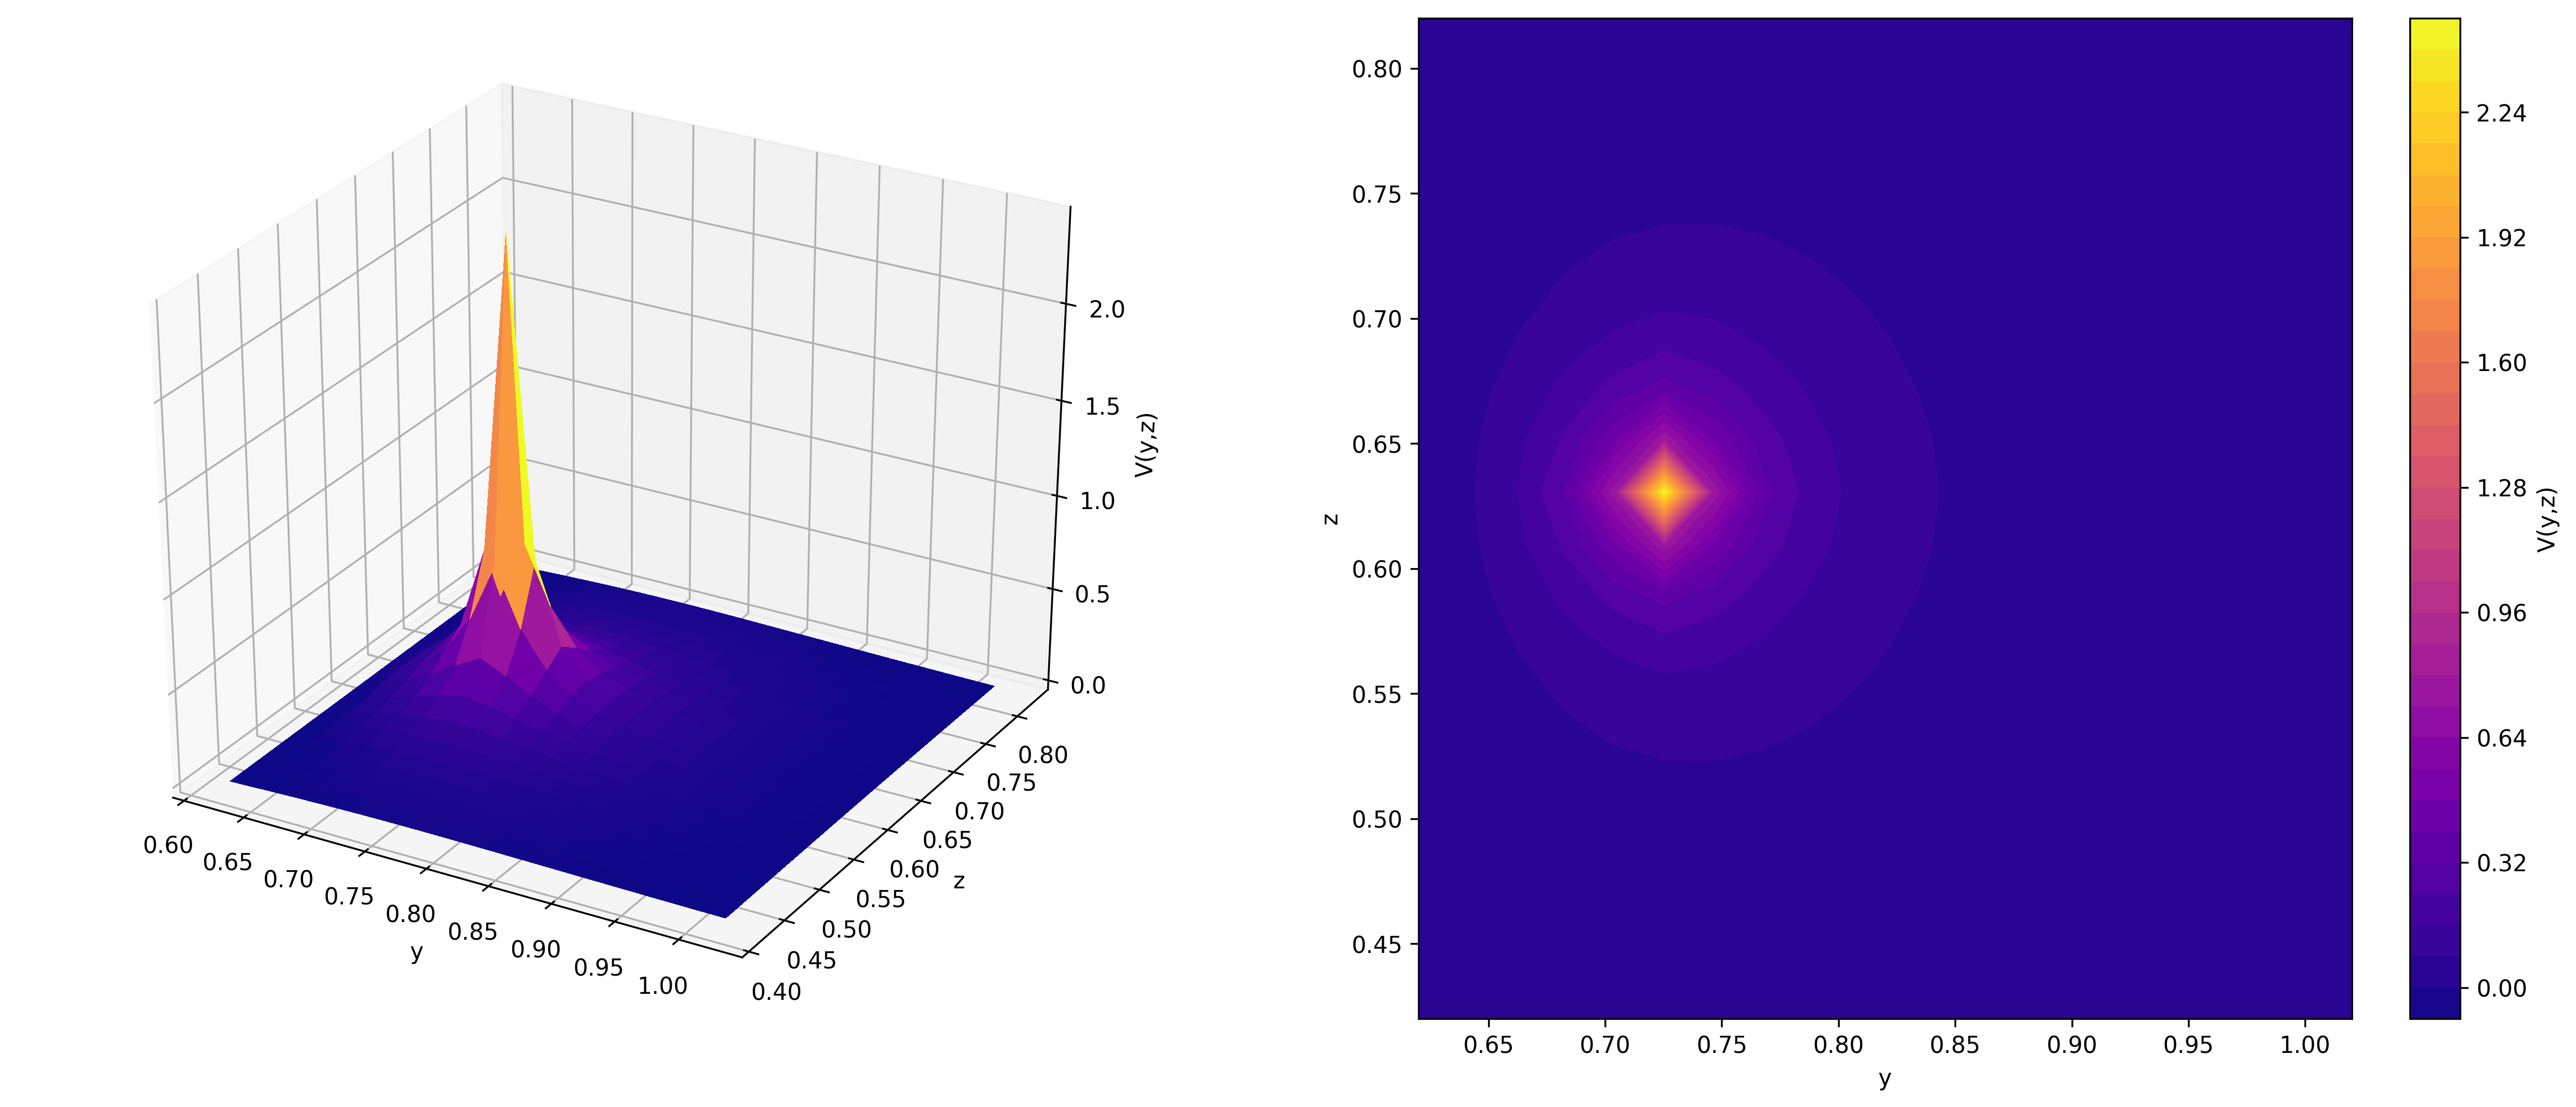

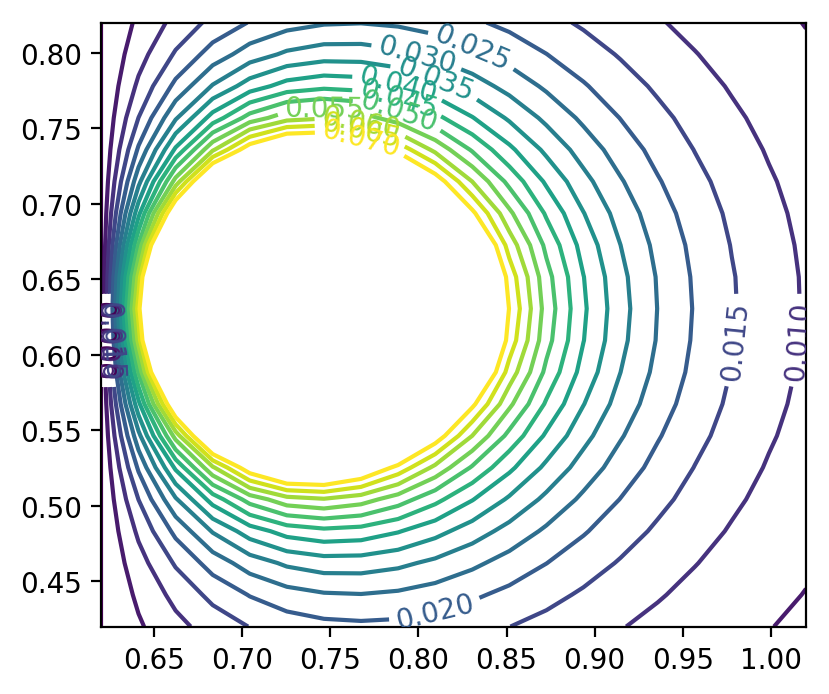

In [38]:
## Plot V
PlotSolution(numxbins, numybins, stepsize, V_mirror[31], x0 = 31, x1 = 51, y0 = 21, y1 = 41, levels = [0 + i * 0.005 for i in range(15)])
plt.show()

In [10]:
V_near_ground = [V_conducting_ground[31][i][j] for i in range(31,41) for j in range(31,41)]
V_near_mirror = [V_mirror[31][i][j] for i in range(31,41) for j in range(31,41)]

In [12]:
# The difference between the two results
[V_near_ground[i]-V_near_mirror[i] for i in range(len(V_near_ground))]

[5.516821231878731e-09,
 5.275327664447463e-09,
 5.404647184040808e-09,
 5.062358878944068e-09,
 5.081704127260883e-09,
 4.662010273172502e-09,
 4.586007104716259e-09,
 4.120370915298588e-09,
 3.972603165862271e-09,
 3.495259349265892e-09,
 3.149545374503404e-09,
 3.264970474536888e-09,
 3.0853809368514007e-09,
 3.1337042127876913e-09,
 2.9006667033593114e-09,
 2.8868744512966504e-09,
 2.61717902558245e-09,
 2.5527786638029903e-09,
 2.2664457498267065e-09,
 2.166947770526617e-09,
 1.9353155467083383e-09,
 1.8449751448823548e-09,
 1.8960467362827416e-09,
 1.7706426741481707e-09,
 1.7829805964986178e-09,
 1.6308850242507944e-09,
 1.609391706708374e-09,
 1.4417516347453585e-09,
 1.3945117820907127e-09,
 1.223389341220571e-09,
 1.0824470764170258e-09,
 1.1256214293986488e-09,
 1.0604331301955483e-09,
 1.0804452610368998e-09,
 9.970537728776208e-10,
 9.954843269155411e-10,
 8.997642006458584e-10,
 8.804577483756404e-10,
 7.793627930519076e-10,
 7.475759560005013e-10,
 6.55684173622717e-10,


In [13]:
## Size of plate and mesh
numxbins = 50
numybins = 50
numzbins = 50
stepsize = 1./50.

## Tolerance and failsafe
epsilon = 1e-3     ## Absolute Error tolerance
imax    = 10000    ## Maximum number of iterations allowed

is_bound = lambda x, y, z: False
f_bound = lambda x, y, z: 0
f_rho = lambda x, y, z: 30 if (x == 26 and y == 26 and z == 26) else 0

## Calculate the scalar function V
V_point_charge = SolvePoisson(numxbins, numybins, numzbins, is_bound, f_bound, f_rho, epsilon, imax)


2 5.0
3 0.8333333333333334
4 0.833333333333333
5 0.3472222222222222
6 0.3472222222222232
7 0.19933127572016462
8 0.19933127572016396
9 0.1331554355281208
10 0.1331554355281206
11 0.09695966220850494
12 0.09695966220850494
13 0.07464263987853337
14 0.07464263987853315
15 0.059744765404050604
16 0.059744765404050604
17 0.04921885222657396
18 0.04921885222657352
19 0.041457800030840763
20 0.0414578000308401
21 0.03554177074543352
22 0.03554177074543308
23 0.030910164651262617
24 0.03091016465126284
25 0.027203854365613456
26 0.02720385436561301
27 0.024183243344193972
28 0.024183243344193528
29 0.021682995416574258
30 0.02168299541657337
31 0.01958571991277469
32 0.0195857199127758
33 0.017806009072077078
34 0.017806009072075746
35 0.016280397103395128
36 0.016280397103395572
37 0.014960843215633624
38 0.014960843215632735
39 0.013810384781253404
40 0.013810384781252516
41 0.012800167502636572
42 0.012800167502636128
43 0.011907372685363349
44 0.011907372685363349
45 0.011113742841772911


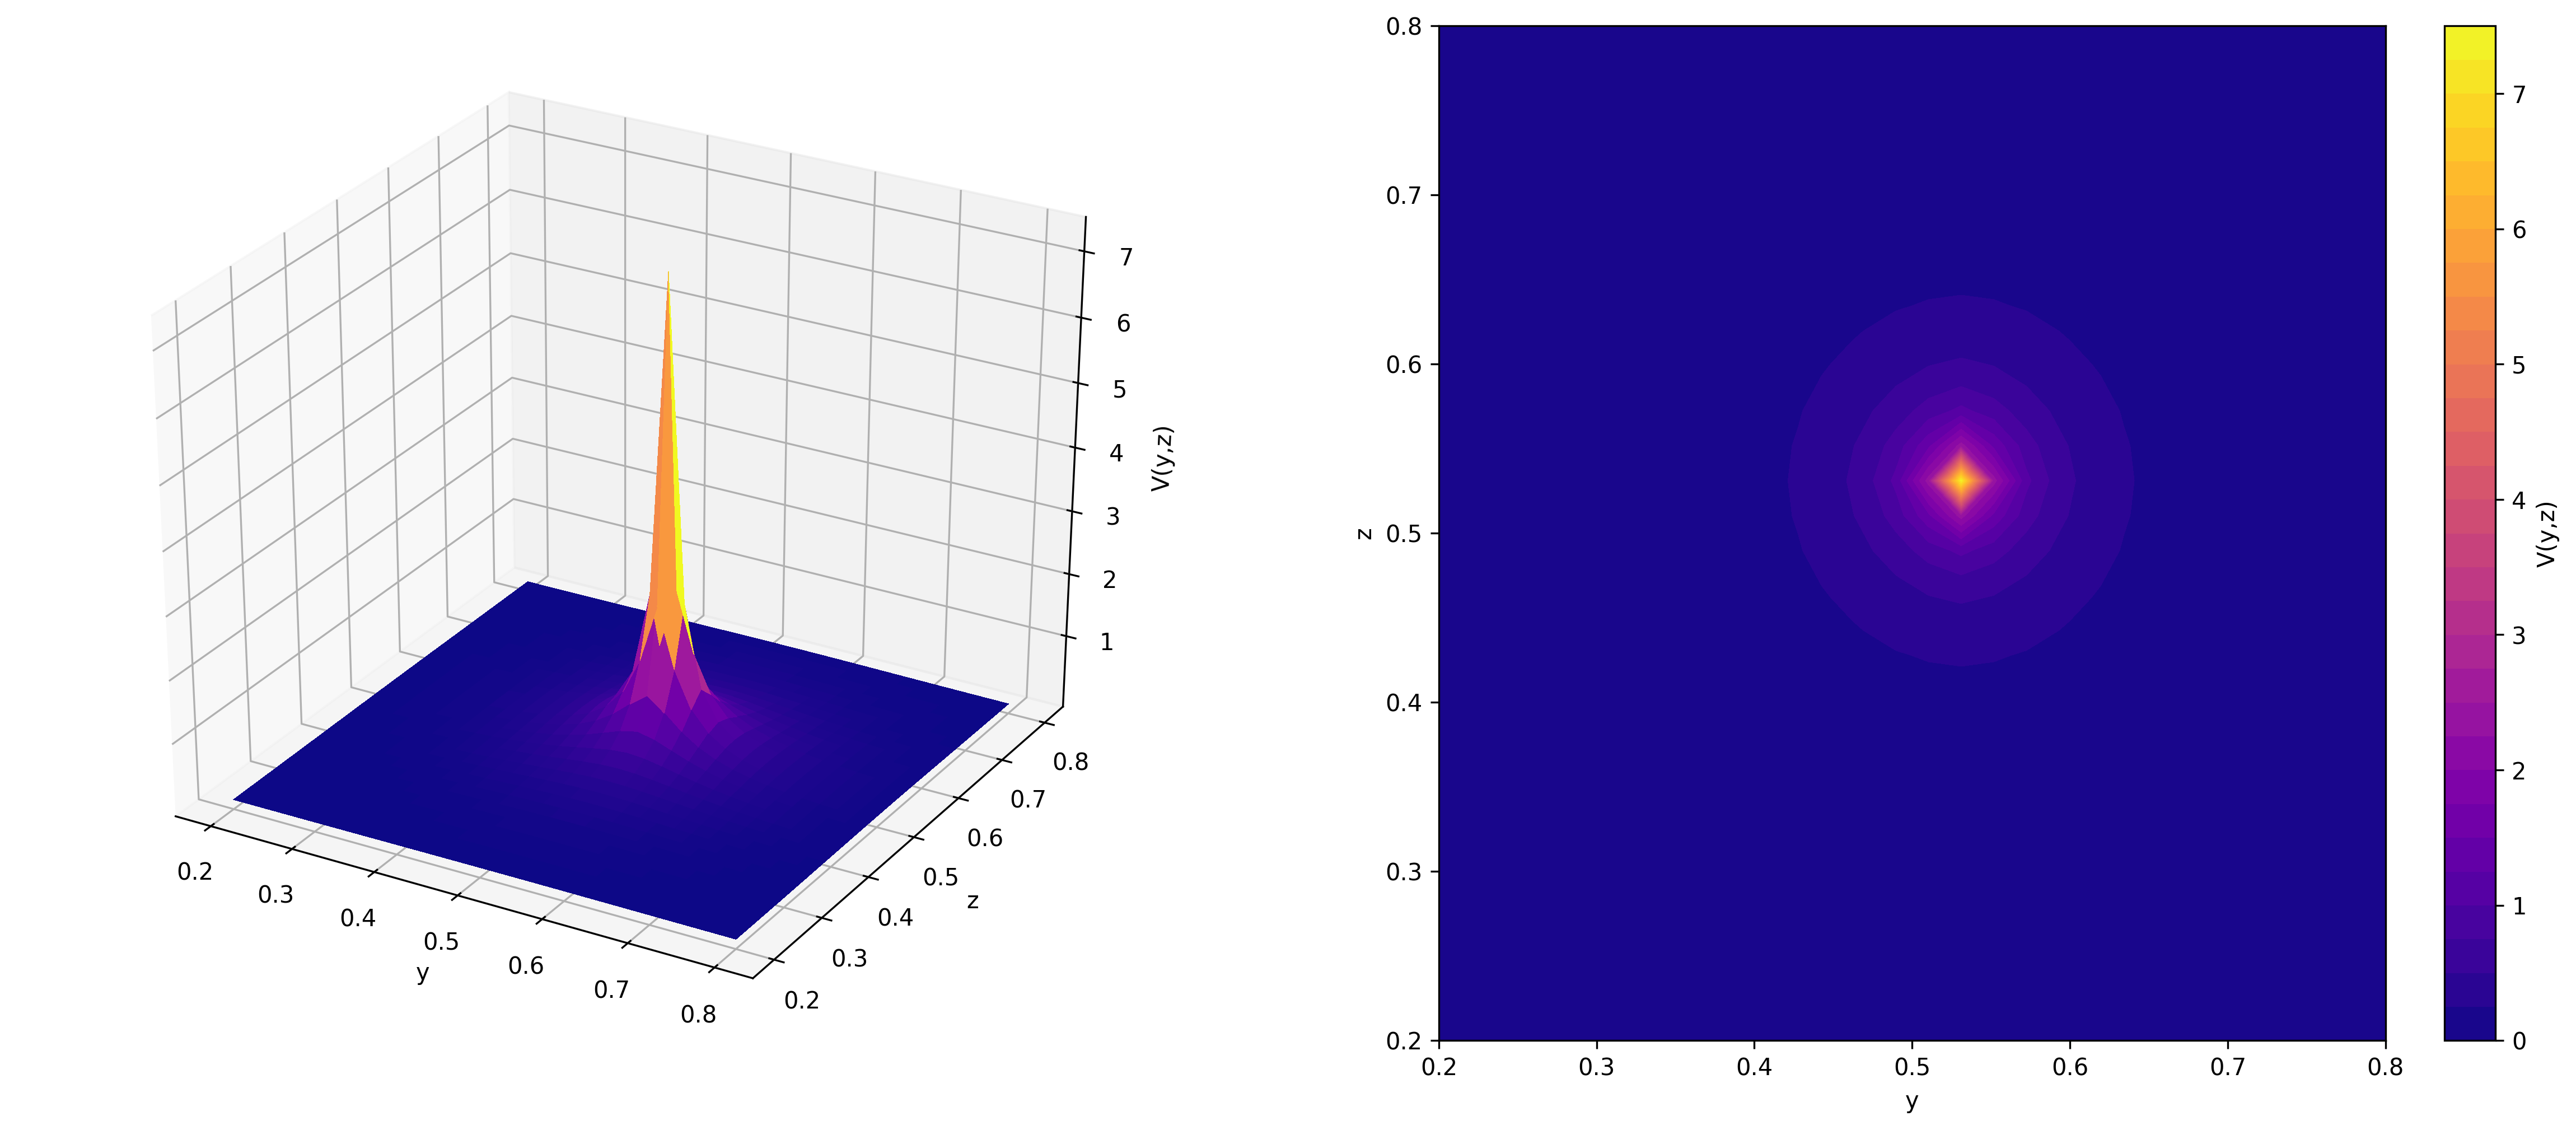

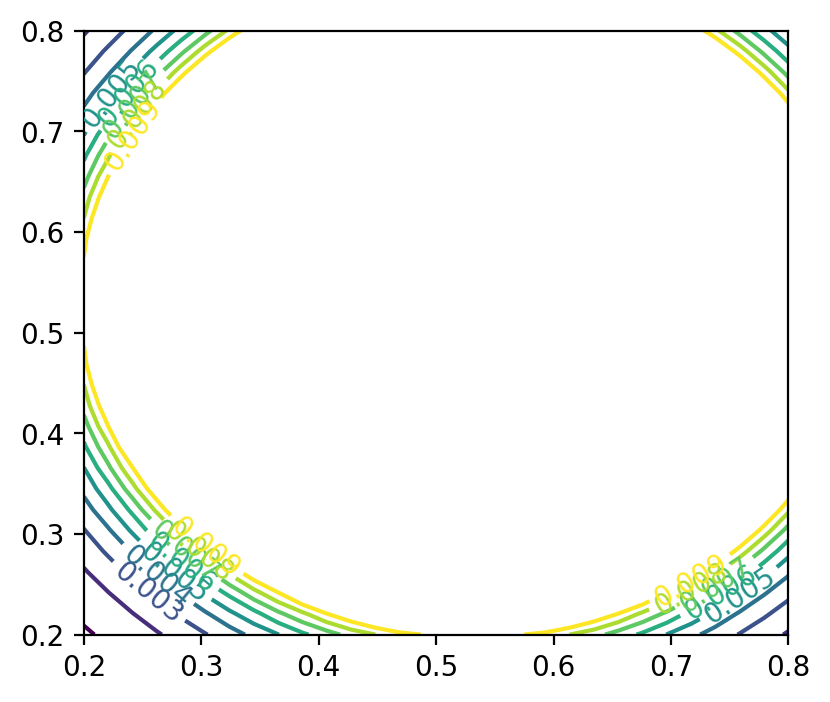

In [40]:
## Plot V
PlotSolution(numxbins, numybins, stepsize, V_point_charge[26], x0 = 10, x1 = 40, y0 = 10, y1 = 40, levels = [0 + i * 0.001 for i in range(10)])
plt.show()

In [15]:
# A function that returns the factor that would make the model a least-square fit
def optimize(guess,steps,low,high,x,y,f_model):
    xs = np.linspace(guess*low,guess*high,steps)
    min_err =  np.sum( (f_model(xs[0],x[j])-y[j])**2 for j in range(len(x)))
    min_err_i = 0
    for i in range(1,steps):
        f = lambda x: f_model(xs[i],x)
        err = sum( (f(x[j])-y[j])**2 for j in range(len(x)))
        if err < min_err:
            min_err = err
            min_err_i = i
    return xs[min_err_i], min_err

Text(0,0.5,'V_classical')

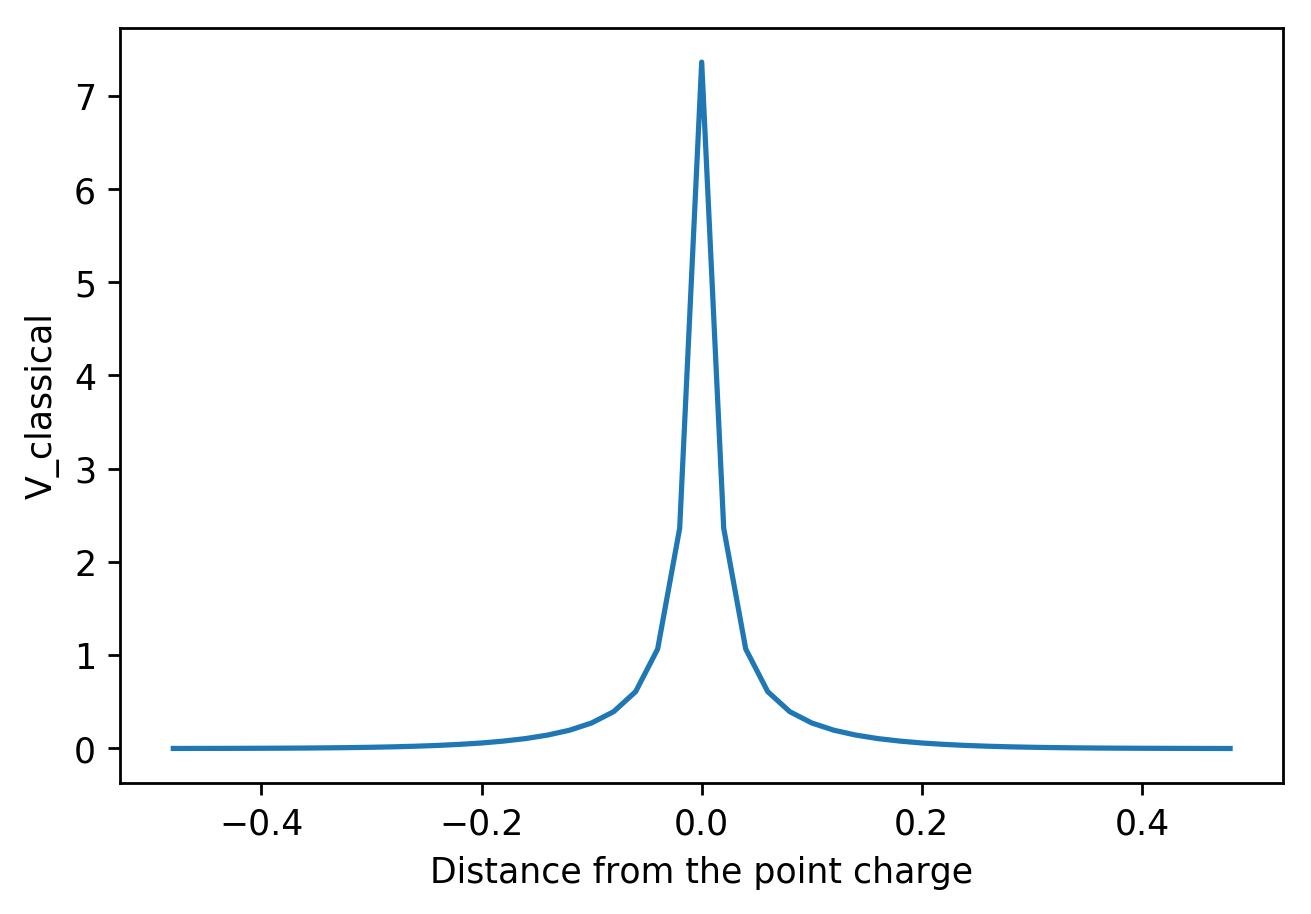

In [34]:
# Plot of potential distribution according to classical theory
start, end = -24, 24
point_charge_potential = [V_point_charge[26][26][i] for i in range(26+start,26+end+1)]
positions = [stepsize*i for i in range(start,end+1)]
plt.figure(dpi=250)
plt.plot(positions, point_charge_potential)
plt.xlabel('Distance from the point charge')
plt.ylabel('V_classical')

In [17]:
#### Size of plate and mesh
numxbins = 50
numybins = 50
numzbins = 50
stepsize = 1./50.
E0 = 20

## Tolerance and failsafe
epsilon = 1e-3     ## Absolute Error tolerance
imax    = 10000    ## Maximum number of iterations allowed

is_bound = lambda x, y, z: False
f_bound = lambda x, y, z: 0
f_rho = lambda x, y, z: 30 if (x == 26 and y == 26 and z == 26) else 0

## Calculate the scalar function V
V_point_charge_BI = SolvePoisson_BI(numxbins, numybins, numzbins, is_bound, f_bound, f_rho, E0, epsilon, imax)


2 5.0
3 0.9079453965902878
4 1.021382852392744
5 0.43483666891804384
6 0.49055330393746477
7 0.26963472178837633
8 0.30513798796926217
9 0.18901042451951278
10 0.21447152998172303
11 0.14231042909069425
12 0.161830226761019
13 0.11230683966857091
14 0.1279344060523364
15 0.09163911776166778
16 0.10453997953051886
17 0.07666827014096511
18 0.08756540899383758
19 0.065403010410092
20 0.07477374935613668
21 0.056668832892391885
22 0.06484355481027482
23 0.04973170239496083
24 0.056947746741754735
25 0.04411119839456723
26 0.05054427435315745
27 0.03948080428422762
28 0.04526427568625735
29 0.035611518139637255
30 0.04084875537490795
31 0.03233839754112955
32 0.037110973384601564
33 0.02953989504706067
34 0.03391318809911947
35 0.027124647830071957
36 0.031151773407281702
37 0.02502277806658393
38 0.028747408153591003
39 0.023180013392469778
40 0.02663843974839697
41 0.021553621469891926
42 0.024776291497009773
43 0.02010954133177023
44 0.02312221932105274
45 0.018820322152018232
46 0.0216

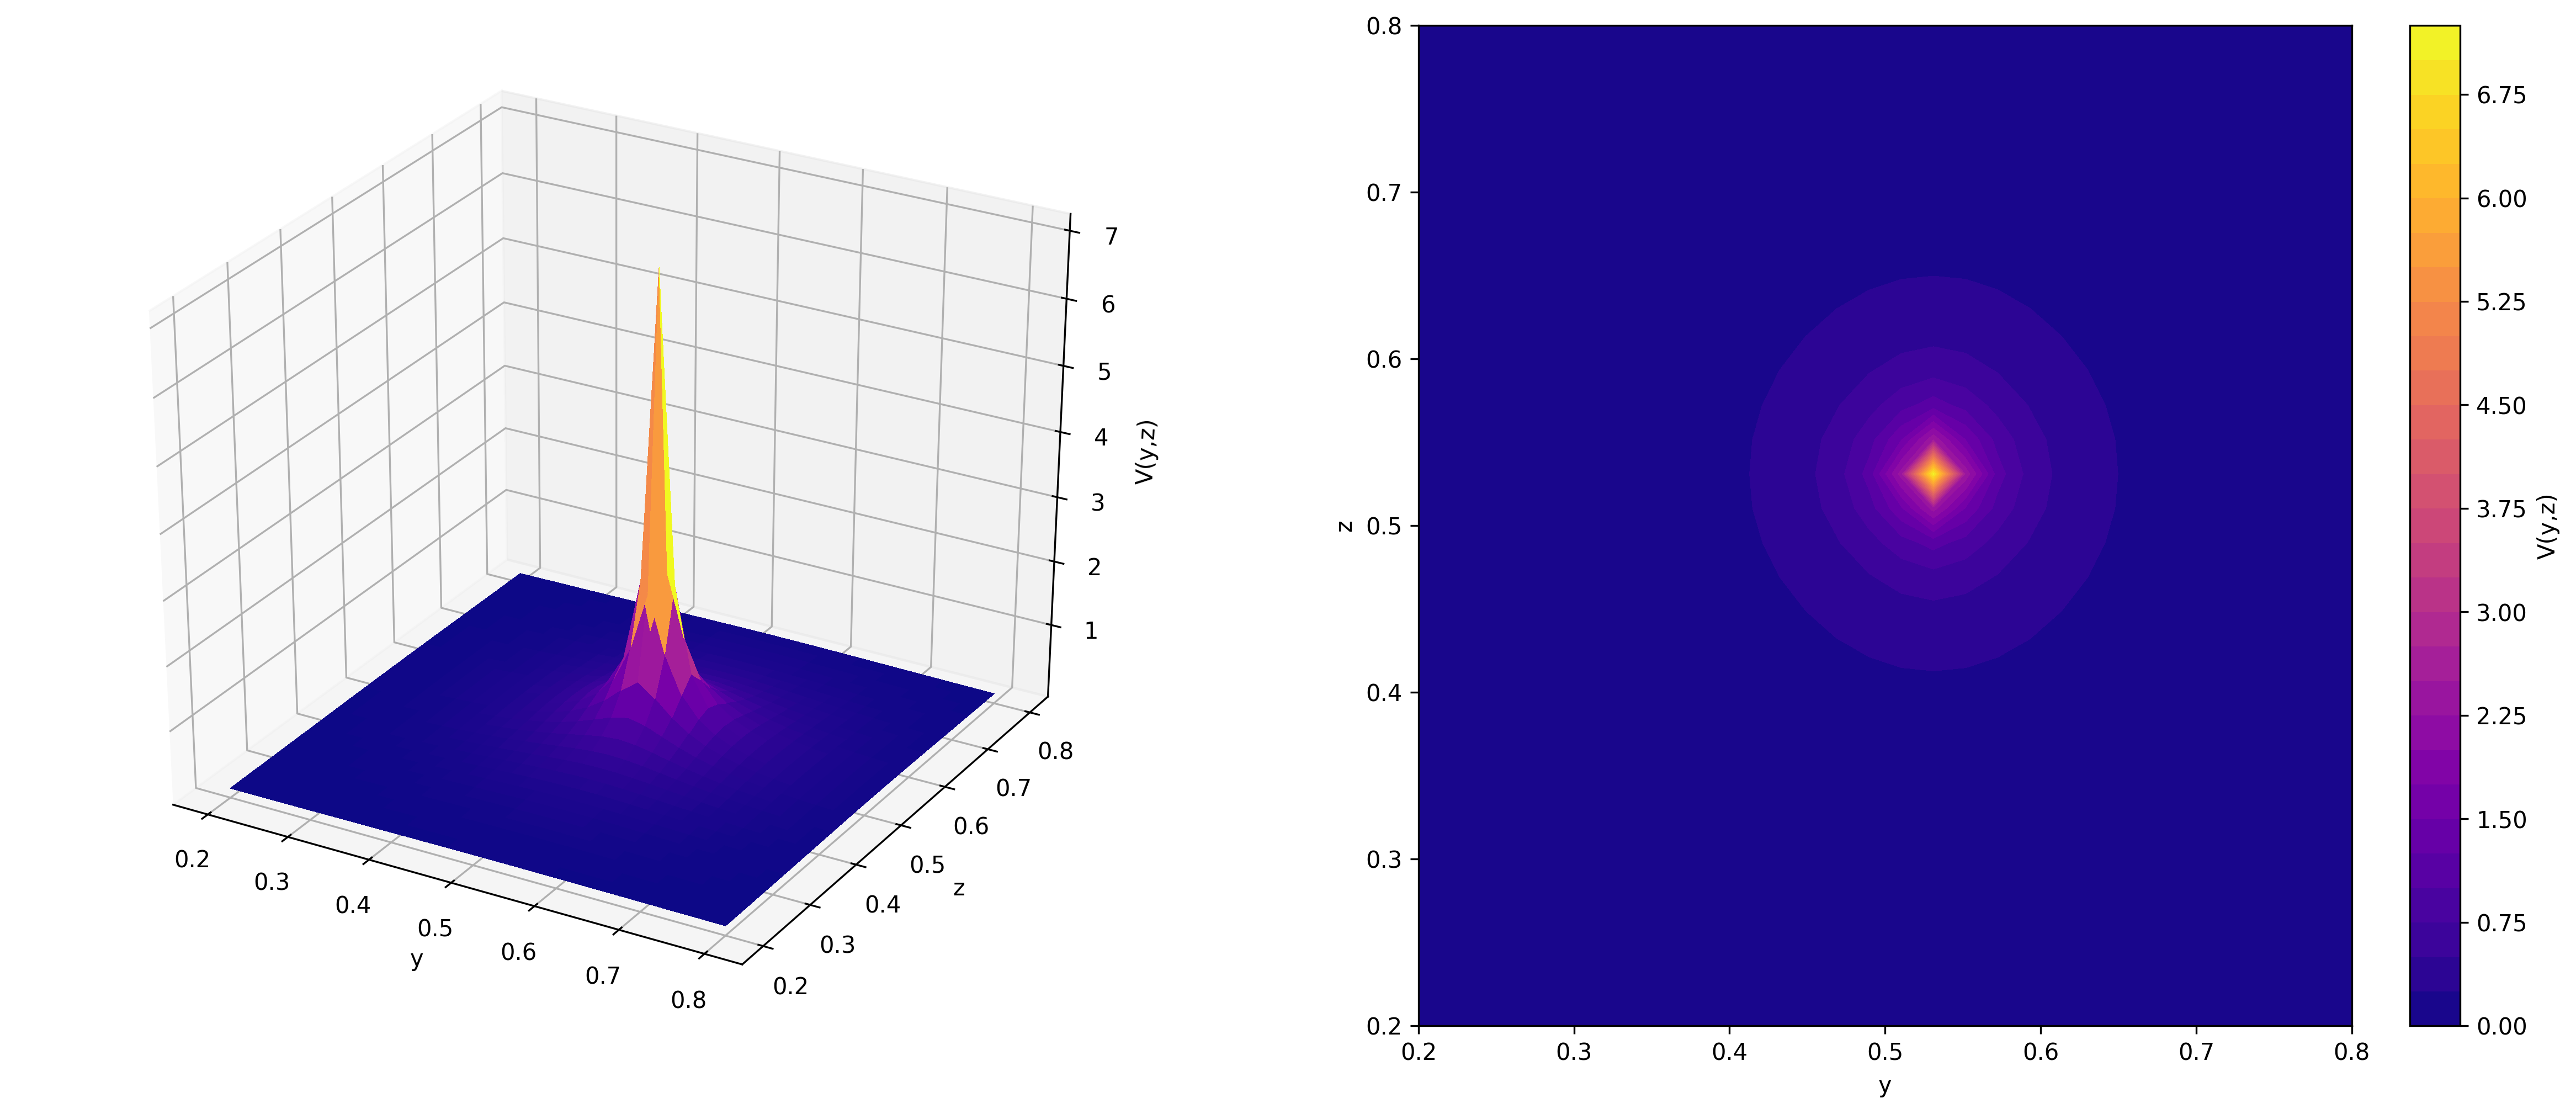

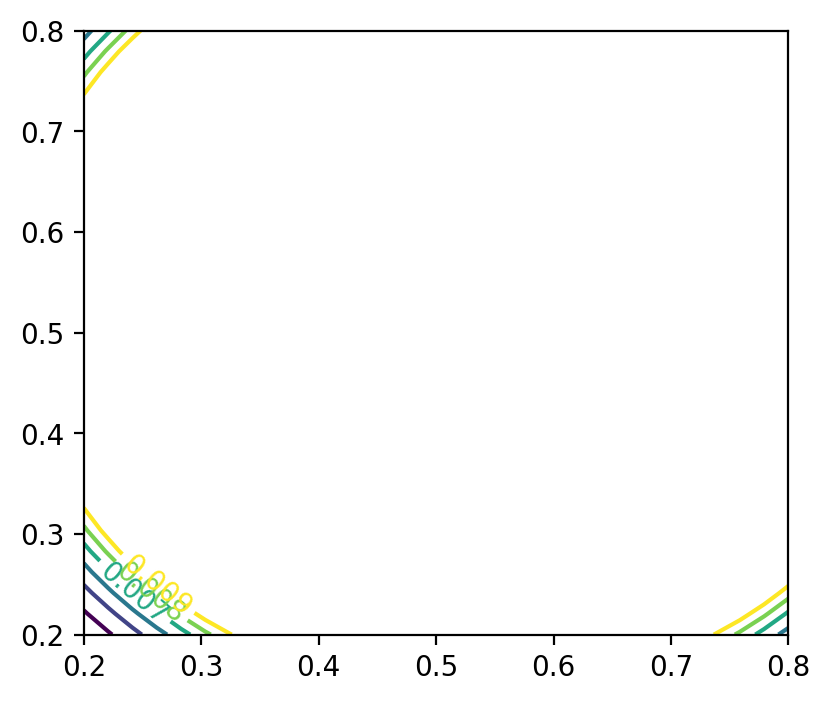

7.098181741648198

In [41]:
## Plot V
PlotSolution(numxbins, numybins, stepsize, V_point_charge_BI[26], x0 = 10, x1 = 40, y0 = 10, y1 = 40, levels = [0 + i * 0.001 for i in range(10)])
plt.show()
max([V_point_charge_BI[i][j][k] for i in range(len(V_point_charge_BI)) for j in range(len(V_point_charge_BI[0])) for k in range(len(V_point_charge_BI[0][0]))])

Text(0,0.5,'Potential')

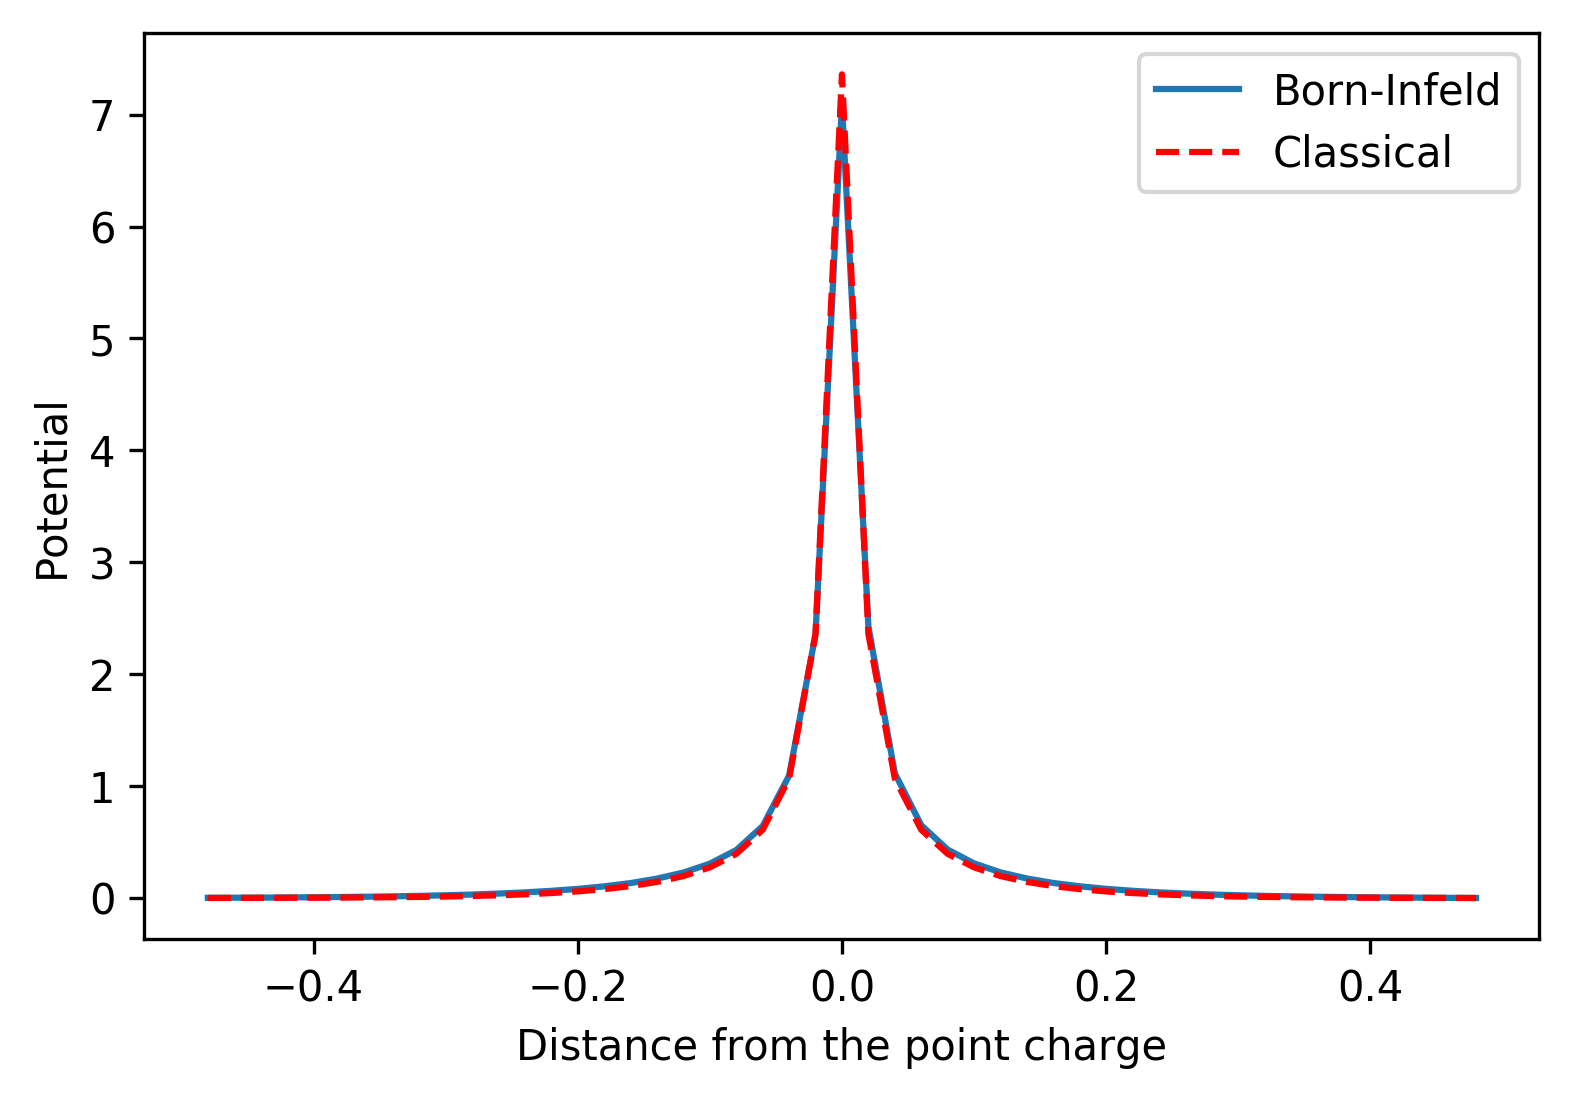

In [19]:
# Plot the potential according to Born-Infeld with the classical results superposed
start, end = -24, 24
point_charge_potential_BI = [V_point_charge_BI[26][26][i] for i in range(26+start,26+end+1)]
positions = [stepsize*i for i in range(start,end+1)]
plt.figure(dpi= 300)
plt.plot(positions, point_charge_potential_BI, label = 'Born-Infeld')
plt.plot(positions, point_charge_potential, 'r--', label = 'Classical')
plt.legend(loc='upper right', fontsize=10)
plt.xlabel('Distance from the point charge')
plt.ylabel('Potential')

Text(0,0.5,'V_classical minus V_BI')

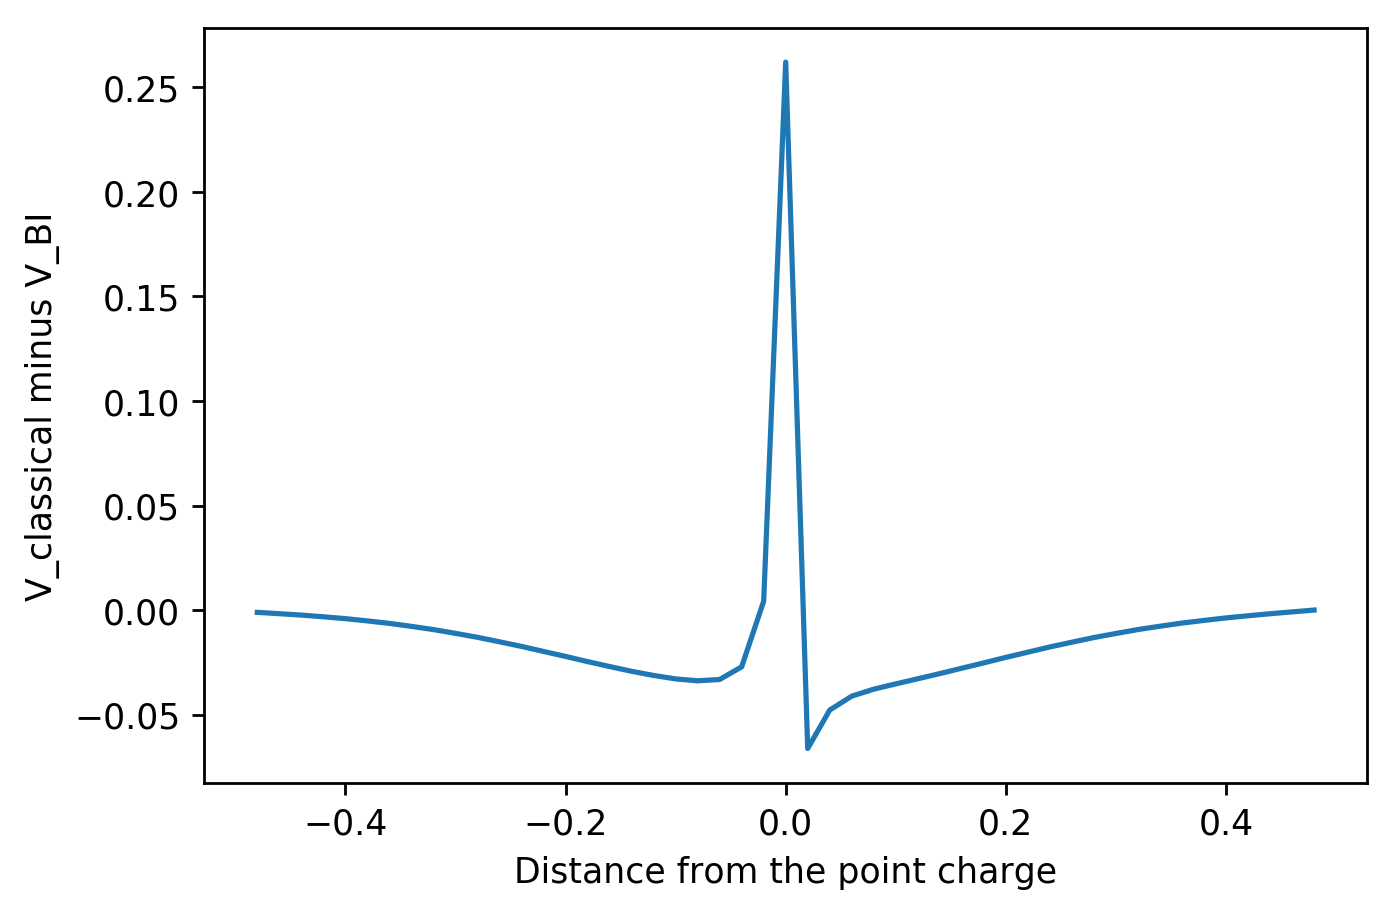

In [30]:
# Plot the difference between the two results
start, end = -24, 24
diff = [V_point_charge[26][26][i] - V_point_charge_BI[26][26][i] for i in range(26+start,26+end+1)]
positions = [stepsize*i for i in range(start,end+1)]
plt.figure(dpi=250)
plt.plot(positions, diff)
plt.xlabel('Distance from the point charge')
plt.ylabel('V_classical minus V_BI')

In [42]:
# A time-dependent ODE solver
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

def quadraticFit(x0,y0,x1,y1,x2,y2):
    # Using Lagrange basis, a quadratic function is fitted to 3 data points
    return (lambda x: y0*(x-x1)*(x-x2)/(x0-x1)/(x0-x2) + y1*(x-x0)*(x-x2)/(x1-x0)/(x1-x2) + y2 * (x-x0)*(x-x1)/(x2-x0)/(x2-x1))
    
def AdamsStep(f, t_old, t_now, f_old, f_now, t_step, y_now):
    f_new = []
    g_new = []
    t_new = t_now + t_step
    for i in range(0,len(y_now)):
        # the guess for f_new vector is generated by linear extrapolation
        f_new.append(f_now[i] + (f_now[i]-f_old[i])/(t_now-t_old) * t_step)
        # the guess vector for y is generated using trapezoidal rule
        g_new.append(y_now[i] + 1/2 * (f_now[i]+f_new[i]) * t_step)
    # the corrected f_new vector is generated by plugging t and y vector into the f function
    f_new_corrected = f(t_new,g_new)
    y_new = []
    for i in range(0,len(y_now)):
        # fit a quadratic function to the 3 points of f values
        quadratic = quadraticFit(t_old,f_old[i],t_now,f_now[i],t_new,f_new_corrected[i])
        # Integrate the quadratic function from t_now to t_new
        increment, err = integrate.quad(quadratic,t_now,t_new)
        y_new.append(y_now[i] + increment)
    # the error indicator is the Euclidean norm in the change between uncorrected and corrected f vectors
    e_i = np.sqrt(sum((f_new[i]-f_new_corrected[i])**2 for i in range(0,len(f_new))))
    return y_new, e_i

def trialStep(f, t_old, t_now, f_old, f_now, t_step, y_now, tol, dtmin):
    # the number of rejections is initialized to 0
    numReject = 0
    # Repeat steps of Adams' method and reject bad steps until the error indicator is smaller than tolerance
    # Or the step size is smaller than the specified minimum.
    while True:
        y_new, e_i = AdamsStep(f, t_old, t_now, f_old, f_now, t_step, y_now)
        if e_i < tol or t_step < dtmin:
            break
        else:
            t_step /= 2
            numReject += 1
    return y_new, t_step, numReject, e_i

def EulerStep(f, t_now, f_now, dt, y_now, tol, dtmin):
    # Euler's method with correction
    while True:
        # The first guess is given by linearly extrapolate using the derivative at t_now
        y_new = [y_now[i]+f(t_now,y_now)[i]*dt for i in range(0,len(y_now))]
        # Correct the guess using trapezoidal rule
        y_new_corrected = [y_now[i]+1/2*(f_now[i]+f(t_now+dt,y_new)[i])*dt for i in range(0,len(y_now))]
        # Error indicator is given by the Euclidean norm of the difference in uncorrected and corrected y vectors
        e_i = np.sqrt(sum((y_new[i]-y_new_corrected[i])**2 for i in range(0,len(y_new))))
        # Repeat until the error indicator is smaller than tolerance or step size is smaller than specified minimum
        if e_i < tol or dt/2 < dtmin:
            break
        else:
            dt /= 2
    return y_new_corrected, dt

def AdamsSolver(f,t0,y0,agrow,ashrink,dtmin,dtmax,endTime,tol, dt = 0.1, growThreshold = 10):
    # ys, ts vectors record each step of the Adams' method
    ys, ts = [], []
    ts.append(t0)
    ys.append(y0)
    t_old = t0
    f_old = f(t0,y0)
    # perform the first step using Euler's method
    y_now, dt = EulerStep(f, t_old, f_old, dt, y0, tol, dtmin)
    
    t_now = t_old + dt
    f_now = f(t_now,y_now)
    ts.append(t_now)
    ys.append(y_now)
    numAccepted = 0
    while True:
        # Perform Adams method while recording how many accepted steps there have been since last rejection
        y_now, dt, numReject, e_i = trialStep(f, t_old, t_now, f_old, f_now, dt, y_now, tol, dtmin)
        if numReject == 0:
            numAccepted += 1
        else:
            numAccepted = 0
        t_old = t_now
        f_old = f_now
        t_now = t_old + dt
        f_now = f(t_now, y_now)
        
        ts.append(t_now)
        ys.append(y_now)
        
        # grow if there have been many accepted steps without rejection
        if numAccepted > growThreshold and e_i < tol/4:
            dt *= agrow
        # shrink if error is to large
        if e_i > 0.75 * tol:
            dt *= ashrink
        # maintain min and max
        if dt < dtmin:
            dt = dtmin
        if dt > dtmax:
            dt = dtmax
            
        # adjust time step near the termination point
        if t_now + dt < endTime < t_now + dt*2:
            dt = (endTime - t_now) / 2
        
        # termination condition
        if t_now + dt > endTime:
            y_now, e_i = AdamsStep(f, t_old, t_now, f_old, f_now, endTime - t_now, y_now)
            break
    return y_now, ys, ts

# A motion simulator that uses the ODE solver
def motionSim(r0,v0,fs,endTime):
    # r0 - initial position; v0 - initial velocity; fs - the force vector; endTime - the end of the simulation
    dim = len(r0)
    f = lambda t, y: [y[i] for i in range(dim,2*dim)] + [f(t,y) for f in fs]
    y0 = [item for item in r0] + [item for item in v0]
    print('f(0,y0) =', f(0,y0))
    y_now, ys, ts = AdamsSolver(f,0,y0,agrow=1.25,ashrink=0.8,dtmin=0.0000001,dtmax=0.001,endTime = endTime,tol=0.01)
    return y_now, ys, ts

In [46]:
# Configure the set-up of problem 5.43 from Griffiths
a, b = 5, 10
m = 2
k = -m/a
q = 1
l = -a**2*(3*m+2*a*k)/(2*b**3-3*a*b**2+a**3)
B = lambda r: k*r + m if r < a else l*(r-a) if a<= r< b else 0
fx = lambda t, y: q*y[3]*B(np.sqrt(y[0]**2 + y[1]**2))
fy = lambda t, y: -q*y[2]*B(np.sqrt(y[0]**2 + y[1]**2))
# A circle
upper_hem = lambda x: np.sqrt(b**2-x**2) if abs(x)<=b else 0
lower_hem = lambda x: -np.sqrt(b**2-x**2) if abs(x)<=b else 0

# Initial speed = 1.89
y_now, ys, ts = motionSim([0,0],[1.89,0],[fx,fy],20)
X_escape = [item[0] for item in ys]
Y_escape = [item[1] for item in ys]

f(0,y0) = [1.89, 0, 0.0, -3.78]


/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


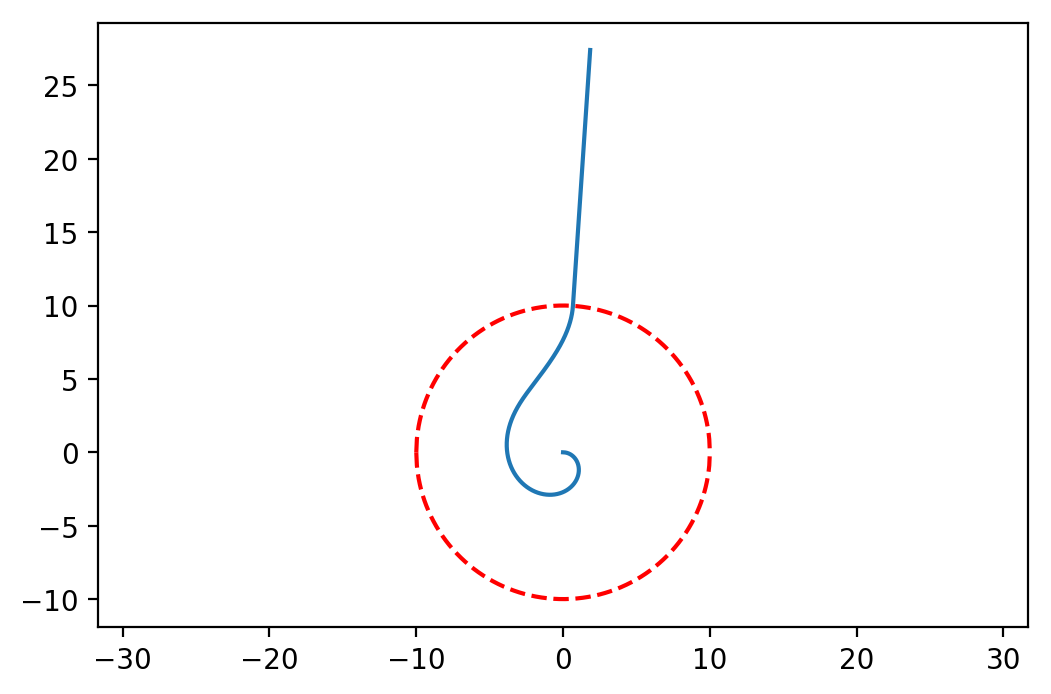

In [47]:
# Plot trajectory and the circle indicating the boundary of the region with magnetic field
plt.figure(dpi=200)
plt.plot(X_escape,Y_escape)

xs = np.linspace(-b,b,500)
ys = [upper_hem(x) for x in xs]
plt.plot(xs,ys,'r--')
ys =[lower_hem(x) for x in xs]
plt.plot(xs,ys,'r--')
plt.axes().set_aspect('equal', 'datalim')

In [26]:
# Now try initial speed = 1.6
y_now, ys, ts = motionSim([0,0],[1.6,0],[fx,fy],20)
X_bound = [item[0] for item in ys]
Y_bound = [item[1] for item in ys]

f(0,y0) = [1.6, 0, 0.0, -3.2]


/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


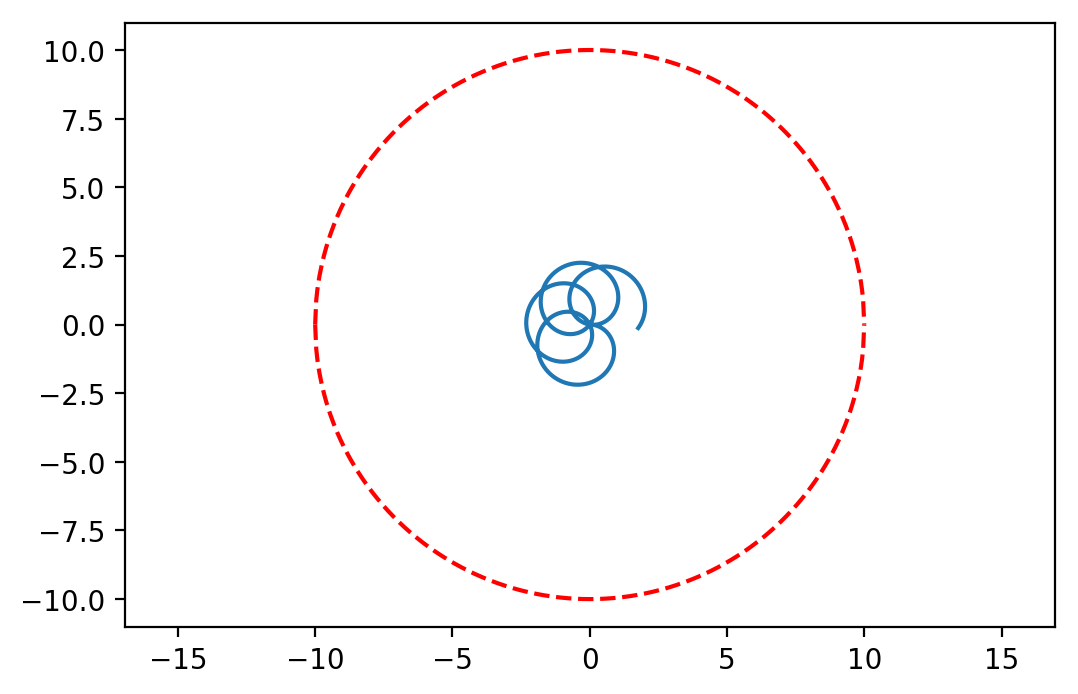

In [27]:
# Plot trajectory and the circle indicating the boundary of the region with magnetic field
plt.figure(dpi=200)
plt.plot(X_bound,Y_bound)
xs = np.linspace(-b,b,500)
ys = [upper_hem(x) for x in xs]
plt.plot(xs,ys,'r--')
ys =[lower_hem(x) for x in xs]
plt.plot(xs,ys,'r--')
plt.axes().set_aspect('equal', 'datalim')

In [50]:
# A scatter simulator based on the motion simulator
def scatterSimulator(e1,e2,k,b,v0):
    y_now, ys, ts = motionSim([10,b],[-v0,0],[(lambda t, y: y[0]*(y[0]**2+y[1]**2)**(-3/2)), (lambda t, y: y[1]*(y[0]**2+y[1]**2)**(-3/2))],20)
    X = [item[0] for item in ys]
    Y = [item[1] for item in ys]
    return(np.arctan(-(ys[len(ys)-1][1]-ys[len(ys)-2][1])/(ys[len(ys)-1][0]-ys[len(ys)-2][0]))), X, Y

In [60]:
# A range of different impact parameters
b_min, b_max = 0.905, 4
divisions = 25
db = (b_max - b_min)/divisions
cs = []
thetas = []
graphs = []

for i in range(divisions+1):
    print(i)
    b = b_min + db*i
    theta_p, _, _ = scatterSimulator(1,1,1,b+db,1)
    theta, X, Y = scatterSimulator(1,1,1,b,1)
    thetas.append(theta)
    graphs.append((X,Y))
    d_theta = theta_p - theta
    cs.append(b/np.sin(theta)*abs(db/d_theta))
    

0
f(0,y0) = [-1, 0, 0.00984331046310504, 0.0010126797804442464]
f(0,y0) = [-1, 0, 0.009878392095201603, 0.0008939944846157451]
1
f(0,y0) = [-1, 0, 0.009803985597525919, 0.0011300073799708373]
f(0,y0) = [-1, 0, 0.00984331046310504, 0.0010126797804442464]
2
f(0,y0) = [-1, 0, 0.009760504344236235, 0.001245830774498313]
f(0,y0) = [-1, 0, 0.009803985597525919, 0.0011300073799708375]
3
f(0,y0) = [-1, 0, 0.009712961820247341, 0.0013600089140710326]
f(0,y0) = [-1, 0, 0.009760504344236235, 0.001245830774498313]
4
f(0,y0) = [-1, 0, 0.009661460938583414, 0.0014724066470401121]
f(0,y0) = [-1, 0, 0.009712961820247341, 0.0013600089140710326]
5
f(0,y0) = [-1, 0, 0.009606111901873623, 0.0015828951191907356]
f(0,y0) = [-1, 0, 0.009661460938583414, 0.0014724066470401123]
6
f(0,y0) = [-1, 0, 0.009547031669122314, 0.001691352130501709]
f(0,y0) = [-1, 0, 0.009606111901873623, 0.0015828951191907356]
7
f(0,y0) = [-1, 0, 0.009484343400142318, 0.0017976624480629747]
f(0,y0) = [-1, 0, 0.009547031669122314, 0.00

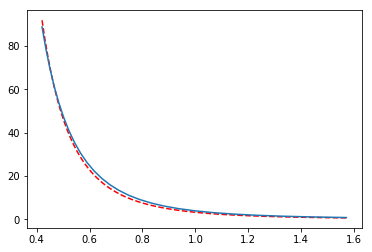

In [61]:
# Provide a guess and then optimize the factor, so as to fit the Rutherford formula to the data
guess = np.sin(thetas[17]/2)**4 * cs[17]
factor, _ = optimize(guess,50,0.9,1.1,thetas,cs,(lambda factor,x: factor / (np.sin(x/2)**4)))
f = lambda x: factor / (np.sin(x/2))**4
xs = np.linspace(min(thetas),max(thetas),100)
ys = f(xs)
plt.plot(xs,ys,'r--')
plt.plot(thetas,cs)

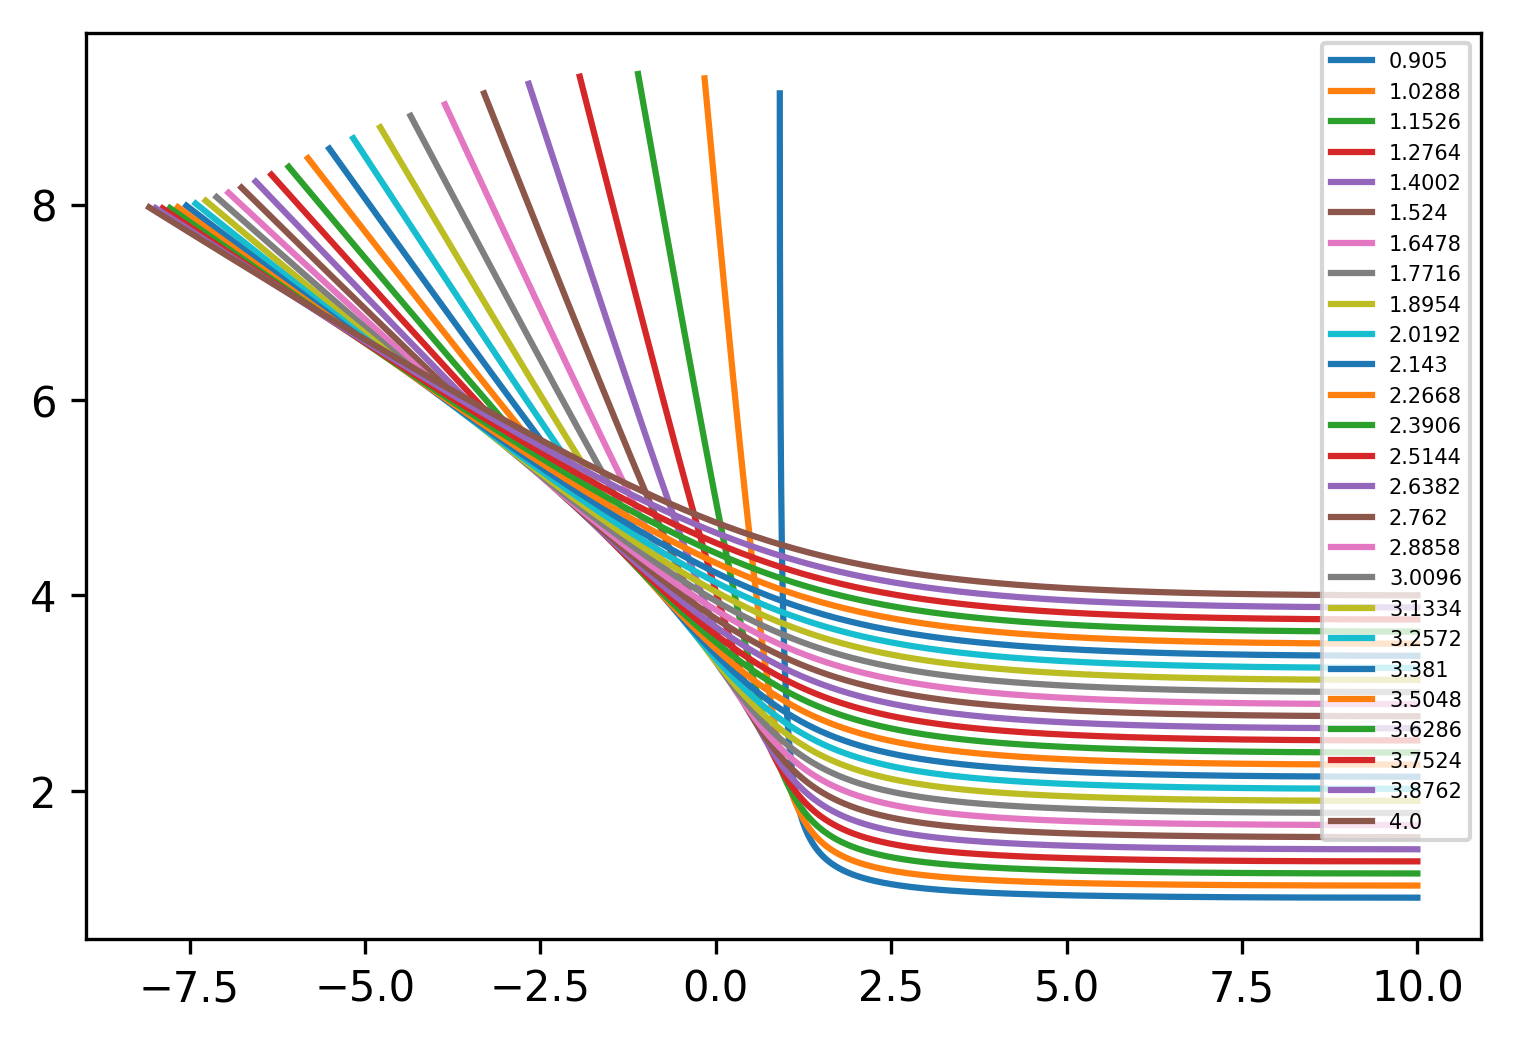

In [62]:
# Plot the trajectories
plt.figure(dpi=300)
for i in range(len(graphs)):
    X, Y = graphs[i]
    b = b_min + db*i
    b = round(b,4)
    plt.plot(X, Y, label = b)
    plt.legend(loc='upper right', fontsize=5)